<a href="https://colab.research.google.com/github/montybbk/darts-time-series/blob/main/darts_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install PyYAML==3.13
#!pip3 install darts

In [2]:
import pandas as pd
import darts
from darts import TimeSeries #Darts data type conversion module
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('https://www.mhlw.go.jp/content/pcr_positive_daily.csv') 
df = df.rename(columns={'日付':'date', 'PCR 検査陽性者数(単日)':'PCR'})
df

,date,PCR
0,2020/1/16,1
1,2020/1/17,0
2,2020/1/18,0
3,2020/1/19,0
4,2020/1/20,0
...,...,...
554,2021/7/23,4204
555,2021/7/24,3576
556,2021/7/25,5009
557,2021/7/26,4661


In [4]:
df.iloc[[len(df)*0.8]]

,date,PCR
447,2021/4/7,3456


In [5]:
ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='PCR')
train, val = ts.split_after(pd.Timestamp('20210407')) #80/20 split

In [11]:
# analyze its seasonality
from darts.utils.statistics import check_seasonality, plot_acf

is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 7.0
periodicity (~years) : 0.6


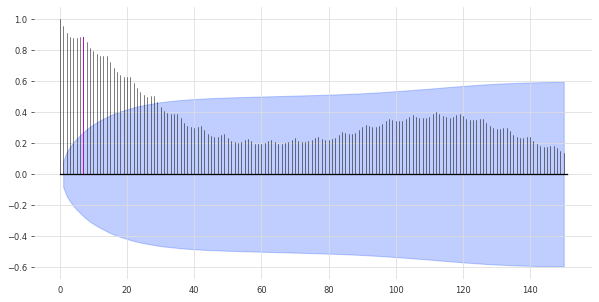

In [12]:
plot_acf(ts, periodicity, max_lag=150)

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None


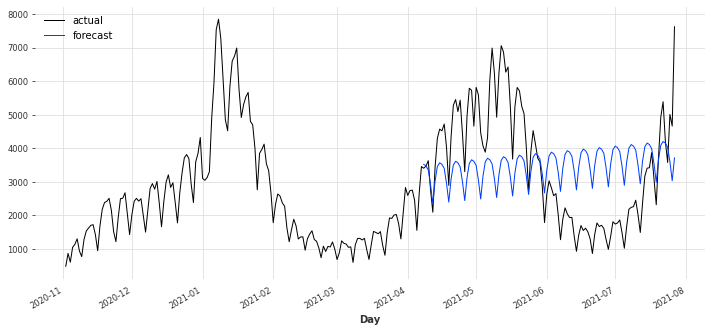

Naive seasonal model, with K=1


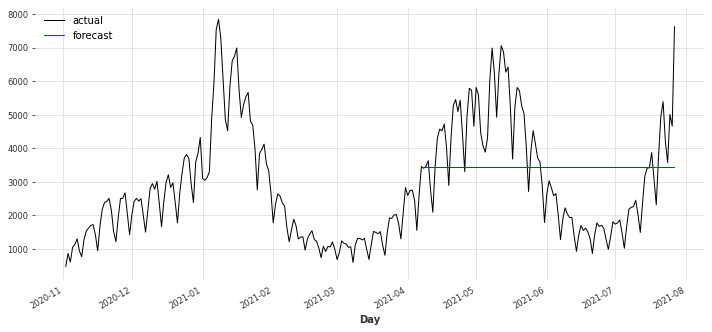

Naive drift model


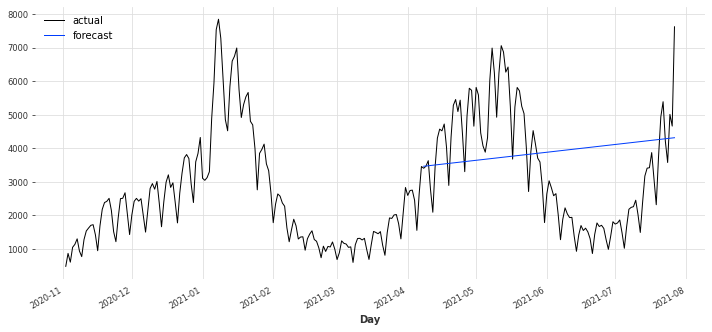

Prophet


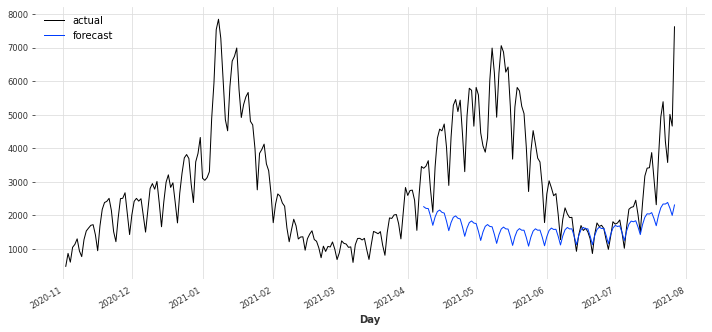

Prophet


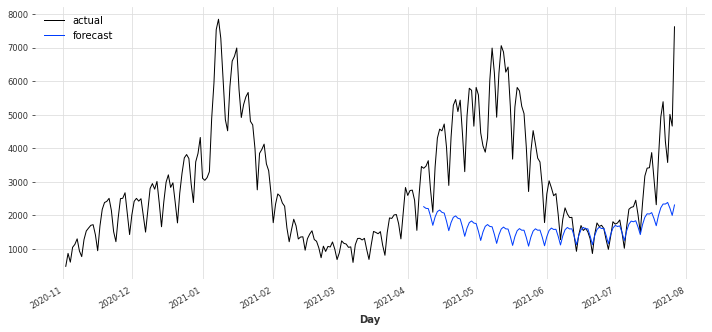

ARIMA(12, 1, 0)


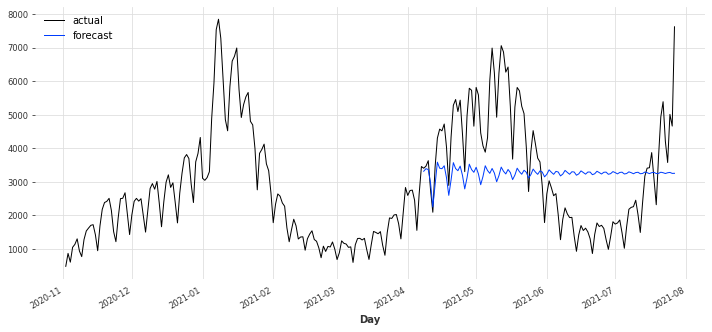

Auto-ARIMA


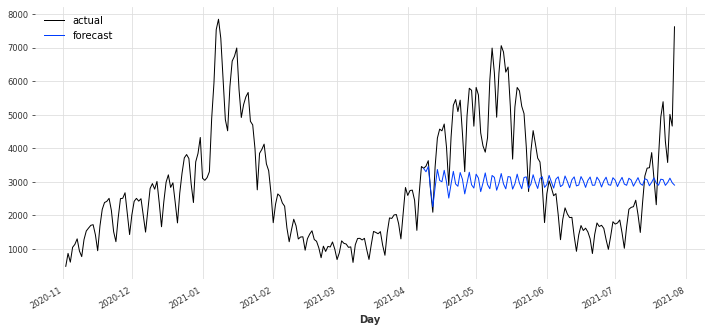

Theta(2)
error¥t :Multiplicative seasonality is not appropriate for zero and negative values
FFT(nr_freqs_to_keep=10, trend=None)


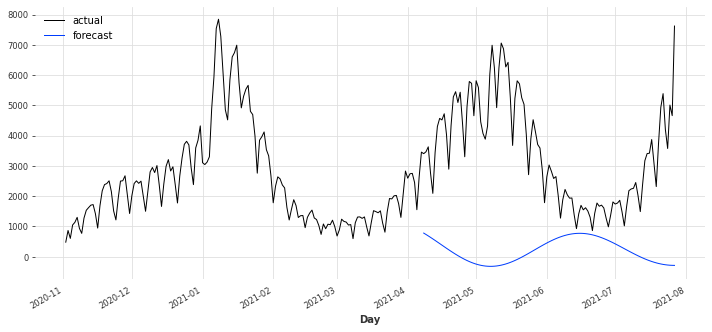

In [6]:
#Import model
from darts.models import ExponentialSmoothing, NaiveSeasonal, NaiveDrift, Prophet, ARIMA
from darts.models import AutoARIMA, RegressionModel, Theta, FFT

models = [ExponentialSmoothing(), 
          NaiveSeasonal(), 
          NaiveDrift(), 
          Prophet(daily_seasonality=True, yearly_seasonality=True), 
          Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True),#Since the number of inspections varies depending on the day of the week, we have prepared a version to see the periodicity of the week.
          ARIMA(), 
          AutoARIMA(), 
          #RegressionModel(), 
          Theta(), 
          FFT()]

for model in models:
    print(model.__str__())
    try: #This is for avoidance because some models will cause an error when executed.
        model.fit(train) #How to sklearn
        prediction = model.predict(len(val))
        #Confirmation by visualization
        plt.figure(figsize=(12, 5))
        ts.split_after(pd.Timestamp('20201101')) [1].plot(label='actual', lw=1) #When displayed from the beginning, it was difficult to see the part that deviated from the important prediction result, so the plot from 20101011
        prediction.plot(label='forecast', lw=1)
        plt.legend()
        plt.xlabel('Day')
        plt.show()
    except Exception as e:
        print('error¥t :{}'.format(e))